In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats
from scipy.stats import mannwhitneyu

from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 1. Data load

In [2]:
data_path = "./data/data.csv"
df = pd.read_csv(data_path)

X= df.iloc[:,2:-1]
y = df.iloc[:,1].replace({'B': '0', 'M': '1'}).astype("int")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

# 2. Feature engineering

## 2.1 Shapiro wilk test(정규성 검정)
H0 : 데이터가 정규 분포를 따른다  
H1 : 데이터가 정규 분포를 따르지 않는다

In [3]:
nomality_list=[]
for column_name in X_train.columns:
  statistic, pvalue = stats.shapiro(df[column_name])
  if pvalue >= 0.05:
    nomality_list.append(column_name)

print(nomality_list)

[]


모든 coloumn 에서 정규성을 확인하지 못했기때문에 비모수 검정인 Mann-Whitney U test 로 각 변수의 종속변수별 집단 분포가 서로 유의미한 차이를 가지는지 검정수행

## 2.2 Mann-Whitney U test
H0 : 두 집단의 분포가 동일하다  
H1 : 두 집단의 분포가 다르다  
우리는 각 변수에 대해 benign 집단과 malignant 집단의 분포가 유의미하게 다르길 원하기 때문에 Mann-Whitney U test 에서 가설이 기각된 column을 사용


In [4]:
# mannwhitneyu 검정
rejected_col_by_mannwhitneyu = []
accepted_by_mannwhitneyu = []
for column_name in X_train.columns:
  list_by_value = []
  for value in y.dropna().unique():
      df_tmp = df[y == value][column_name].dropna()
      list_by_value.append(np.array(df_tmp))
  statistic, pvalue = mannwhitneyu(*list_by_value)
  if pvalue < 0.05:
    rejected_col_by_mannwhitneyu.append(column_name)
  else:
     accepted_by_mannwhitneyu.append(column_name)

print("rejected by mannwhitneyu : ", len(rejected_col_by_mannwhitneyu), rejected_col_by_mannwhitneyu)
print("acepted by mannwhitneyu : ", len(accepted_by_mannwhitneyu), accepted_by_mannwhitneyu)

rejected by mannwhitneyu :  27 ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'radius_se', 'perimeter_se', 'area_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
acepted by mannwhitneyu :  3 ['fractal_dimension_mean', 'texture_se', 'smoothness_se']


실제로 Mann-Whitney U test에서 채택된 coloumn의 두 집단 분포가 서로 비슷한지 시각화로 확인

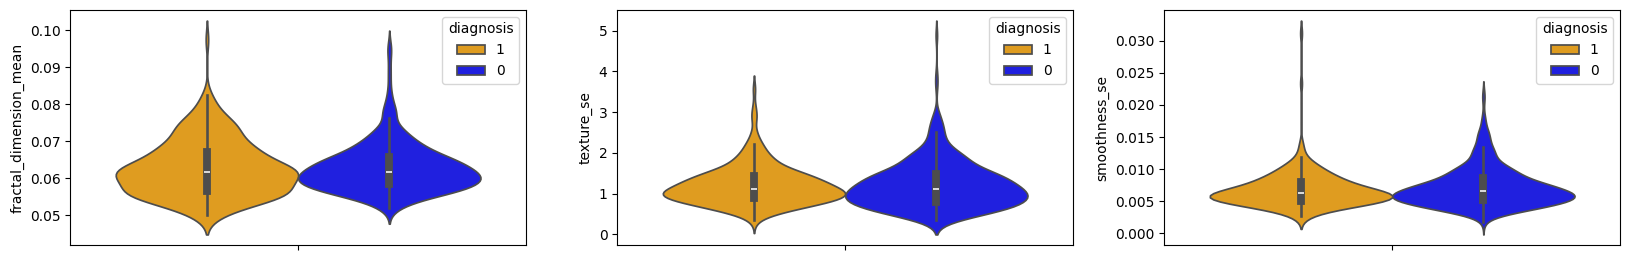

In [5]:
plt.figure(figsize=(20, ((len(X[accepted_by_mannwhitneyu].columns) // 3) + 1) * 3))
x = 1
plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.5, wspace=0.2)

for column_name in X[accepted_by_mannwhitneyu].columns:
    plt.subplot((len(X[accepted_by_mannwhitneyu].columns) // 3) + 1, 3, x)
    x += 1
    sns.violinplot(data=df, x=None, y=column_name, hue=y.astype(str), 
                   palette={"0": "blue", "1": "orange"})  # hue로 y 전달, legend 비활성화
plt.show()


## 2.3 Variance Inflation Factors
입력 변수 X 변수 간의 상관관계가 너무 높다면 모델 성능 저하 및 복잡도 향상 문제가 있기때문에 확인후 제거

In [6]:
vif_X = X_train[rejected_col_by_mannwhitneyu].copy()
drop_col_by_vif=[]
while(True):
    vif_list= [variance_inflation_factor(vif_X.values, i).item() for i in range(vif_X.shape[1])]
    max_vif_cal=vif_X.columns[np.argmax(vif_list)]
    if max(vif_list)<10:
        break 
    drop_col_by_vif.append(max_vif_cal)
    vif_X.drop(max_vif_cal,axis=1,inplace=True)

final_list= vif_X.columns.to_list()

In [7]:
def caculate_vif(X):
  vif = pd.DataFrame()
  vif['VIF_Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  vif['Feature'] = X.columns
  return vif.sort_values('VIF_Factor',ascending=False).reset_index(drop=True)
  
caculate_vif(vif_X)

,VIF_Factor,Feature
0,6.771562,symmetry_se
1,6.346548,fractal_dimension_se
2,6.280486,texture_worst
3,6.262901,concave points_mean
4,4.756723,concavity_se
5,3.890361,area_se


In [8]:
X_train = X_train[final_list]
X_test = X_test[final_list]

# 3. Model training

## 3.1 Make final X , split data, and standardization

In [9]:
scaler =  StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

# Logistic Regression

lgleg f1_score :  0.9774436090225563


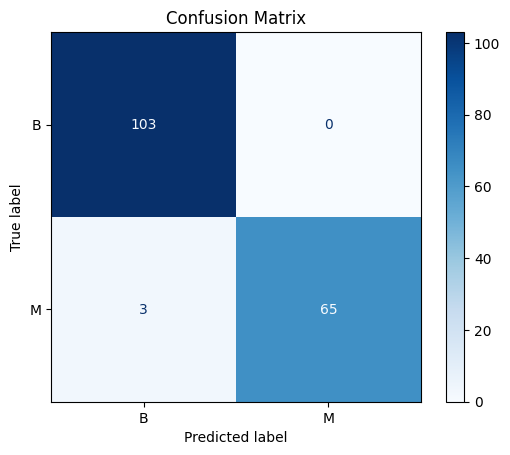

In [10]:
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
y_pred_logleg = logreg.predict(X_test_scaled)  ##

logreg_f1 = f1_score(y_test, y_pred_logleg)

print("lgleg f1_score : ", logreg_f1)

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_logleg), display_labels=["B", "M"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Support vector machine

svc f1_score :  0.9705882352941176


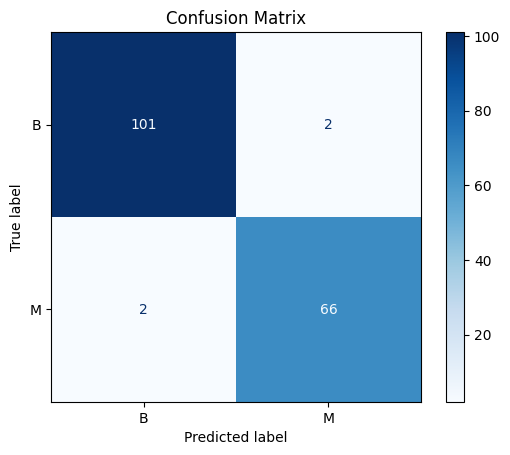

In [11]:
svc = SVC(kernel="linear")
svc.fit(X_train_scaled, y_train)
y_pred_svc = svc.predict(X_test_scaled)  ##

svc_f1 = f1_score(y_test, y_pred_svc)

print("svc f1_score : ", svc_f1)

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_svc), display_labels=["B", "M"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Random Forest

f1_score :  0.9496402877697842


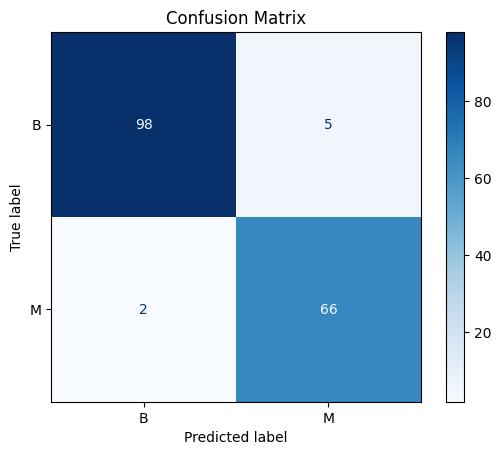

In [12]:
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

rf_f1 = f1_score(y_test, y_pred_rf)

print("f1_score : ", rf_f1)

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf), display_labels=["B", "M"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Xgboost

f1_score :  0.9420289855072463


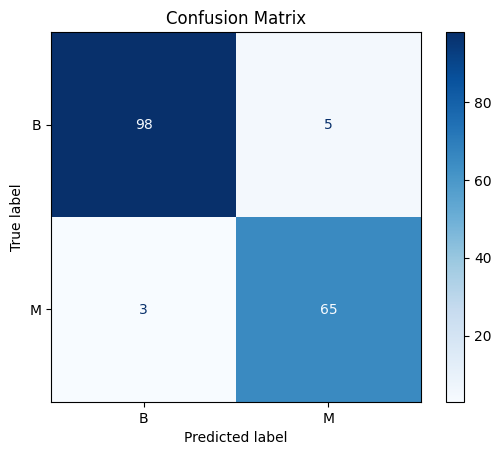

In [13]:
xgb = XGBClassifier()
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)  ##

xgb_f1 = f1_score(y_test, y_pred_xgb)

print("f1_score : ", xgb_f1)

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xgb), display_labels=["B", "M"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [14]:
print ('F1_score Comparisons for Binary Models\n')
print ('logreg_score:', '{0:0.5f}'.format(logreg_f1))
print ('svc_score   :', '{0:0.5f}'.format(svc_f1))
print ('rfc_score   :', '{0:0.5f}'.format(rf_f1))
print ('xgb_score   :', '{0:0.5f}'.format(xgb_f1))


F1_score Comparisons for Binary Models

logreg_score: 0.97744
svc_score   : 0.97059
rfc_score   : 0.94964
xgb_score   : 0.94203


# 4 Model analysis

loglag coefficient :  ['concave points_mean', 'area_se', 'texture_worst', 'concavity_se', 'symmetry_se', 'fractal_dimension_se']


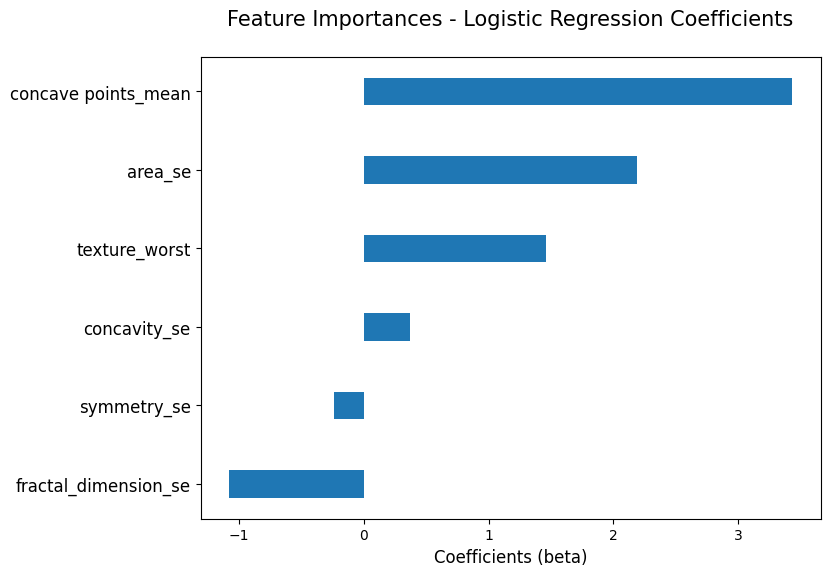

In [19]:
indices =  np.argsort(sum(logreg.coef_))
print("loglag coefficient : ", X_test.columns[np.flip(indices)].to_list())
plt.figure(figsize=(8, 6))
plt.barh(X_test.columns, sum(logreg.coef_)[indices], .35, align='center')
plt.yticks(X_test.columns, X_test.columns[indices], fontsize=12)
plt.xlabel('Coefficients (beta)', fontsize=12)
plt.title('Feature Importances - Logistic Regression Coefficients\n', fontsize=15)
plt.show()

svc coefficient :  ['concave points_mean', 'area_se', 'texture_worst', 'concavity_se', 'symmetry_se', 'fractal_dimension_se']


<Figure size 800x600 with 0 Axes>

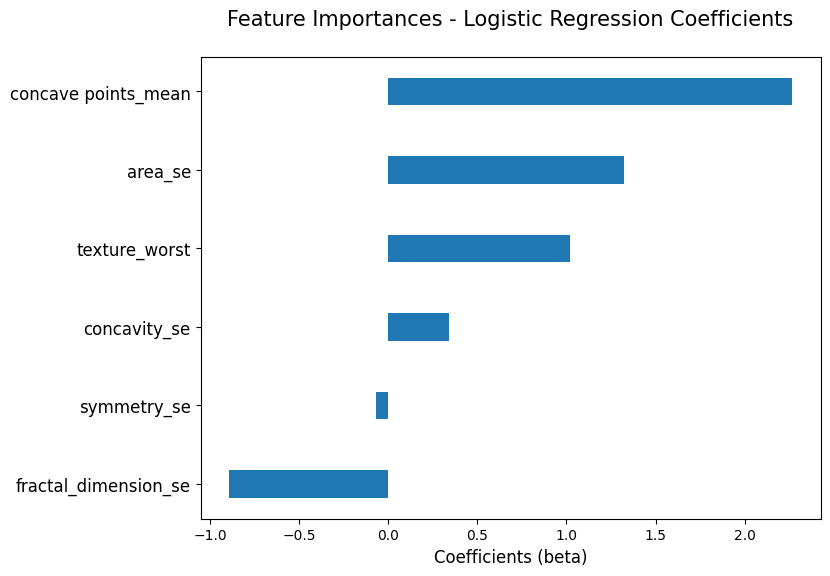

In [21]:
indices =  np.argsort(sum(svc.coef_))
print("svc coefficient : ", X_test.columns[np.flip(indices)].to_list())
plt.figure(figsize=(8, 6))
plt.figure(figsize=(8, 6))
plt.barh(X_test.columns, sum(svc.coef_)[indices], .35, align='center')
plt.yticks(X_test.columns, X_test.columns[indices], fontsize=12)
plt.xlabel('Coefficients (beta)', fontsize=12)
plt.title('Feature Importances - Logistic Regression Coefficients\n', fontsize=15)
plt.show()

rf important col:  ['concave points_mean', 'area_se', 'texture_worst', 'concavity_se', 'fractal_dimension_se', 'symmetry_se']


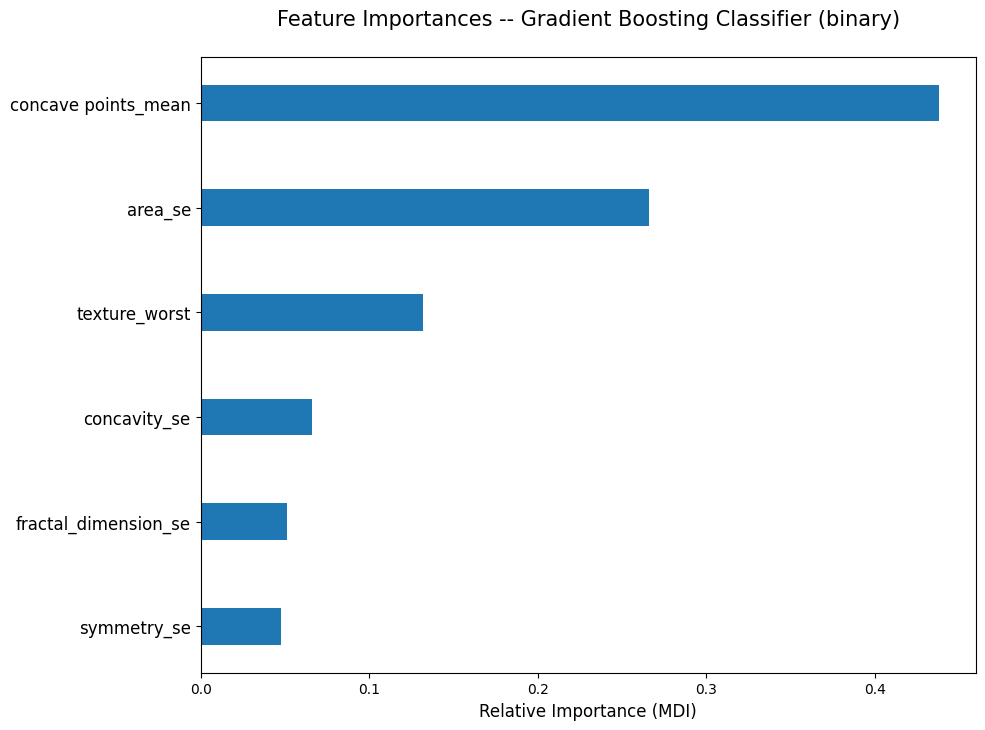

In [25]:
indices = np.argsort(rf.feature_importances_)  # 중요도 크기 순으로 정렬
print("rf important col: ", X_test.columns[np.flip(indices)].to_list())
plt.figure(figsize=(10, 8))

plt.barh(X_test.columns, rf.feature_importances_[indices], .35, align='center')
plt.yticks(X_test.columns, X_test.columns[indices], fontsize=12)

plt.xlabel('Relative Importance (MDI)', fontsize=12)
plt.title('Feature Importances -- Gradient Boosting Classifier (binary)\n', fontsize=15)
plt.show()

xgb important col:  ['concave points_mean', 'texture_worst', 'area_se', 'fractal_dimension_se', 'symmetry_se', 'concavity_se']


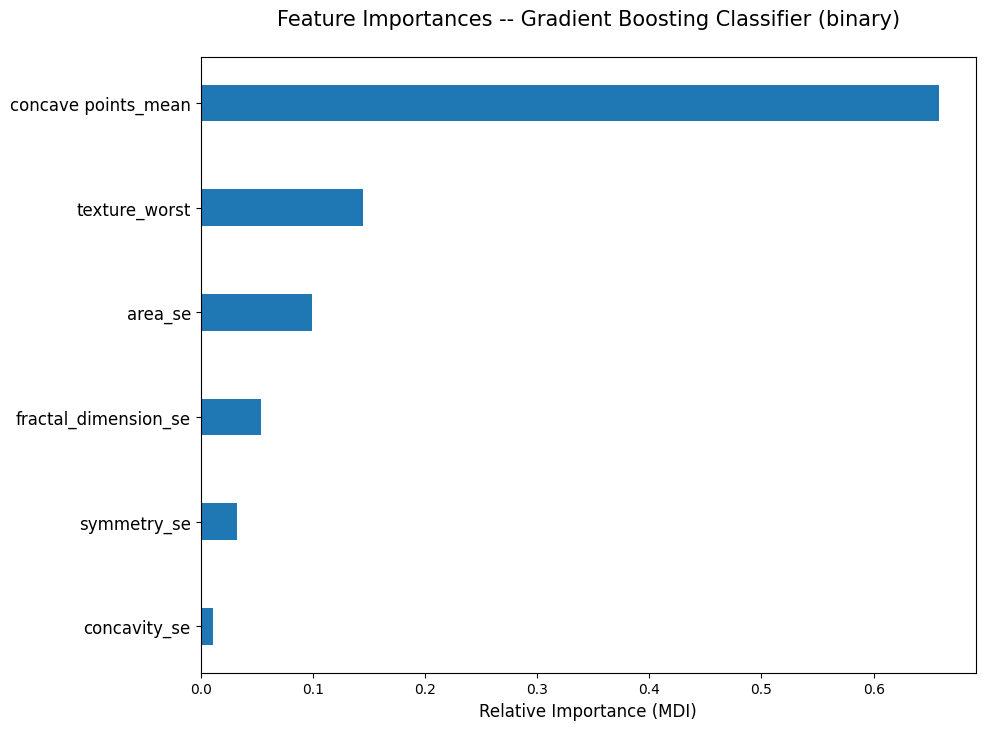

In [26]:
indices = np.argsort(xgb.feature_importances_)  # 중요도 크기 순으로 정렬
print("xgb important col: ", X_test.columns[np.flip(indices)].to_list())
plt.figure(figsize=(10, 8))

plt.barh(X_test.columns, xgb.feature_importances_[indices], .35, align='center')
plt.yticks(X_test.columns, X_test.columns[indices], fontsize=12)

plt.xlabel('Relative Importance (MDI)', fontsize=12)
plt.title('Feature Importances -- Gradient Boosting Classifier (binary)\n', fontsize=15)
plt.show()